In [1]:
from chesslab.agent_tf import agent
from chesslab.agent_stockfish import agent as s_agent
from chesslab.tests import kaufman_test
from chesslab.agent_mcts_v2 import agent_MCTS
import chess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf
class Model_1():

    def __init__(self,
                   n_classes=2):
        initializer = tf.keras.initializers.GlorotNormal()
        self.hw=[]
        self.hb=[]

        self.hw.append( tf.Variable(initializer(shape=(7,7,3,32),dtype=np.float32),name="hl1weigths",dtype="float32") )
        self.hb.append( tf.Variable(np.zeros(32,dtype=np.float32),name="hl1bias",dtype="float32") )
        #8x8x32
        self.hw.append( tf.Variable(initializer(shape=(5,5,32,64),dtype=np.float32),name="hl2weigths",dtype="float32"))
        self.hb.append( tf.Variable(np.zeros(64,dtype=np.float32),name="hl2bias",dtype="float32"))
        #8x8x64
        self.hw.append( tf.Variable(initializer(shape=(3,3,64,128),dtype=np.float32),name="hl3weigths",dtype="float32"))
        self.hb.append( tf.Variable(np.zeros(128,dtype=np.float32),name="hl3bias",dtype="float32"))
        #8x8x128
        self.hw.append( tf.Variable(initializer(shape=(8*8*128,256),dtype=np.float32),name="hl4weigths",dtype="float32"))
        self.hb.append( tf.Variable(np.zeros(256,dtype=np.float32),name="hl4bias",dtype="float32"))

        self.hw.append( tf.Variable(initializer(shape=(256, n_classes),dtype=np.float32),name="outweigths",dtype="float32"))
        self.hb.append( tf.Variable(np.zeros(n_classes,dtype=np.float32),name="outbias",dtype="float32"))

        self.trainable_variables = []
        for i in range(len(self.hw)):
            self.trainable_variables.append(self.hw[i])    
            self.trainable_variables.append(self.hb[i])

    def __call__(self,x): 

        # Declarando la arquitectura
        out = tf.cast(x, tf.float32)
        out = tf.reshape(out, shape=[-1, 8, 8, 3])

        layer=0
        out = tf.add(out, 1e-8)
        out = tf.nn.conv2d(out,self.hw[layer], strides=[1,1,1,1], padding='SAME')  
        out = tf.add(out, self.hb[layer])
        out = tf.nn.elu(out)
              #8*8*32
        layer+=1
        out = tf.nn.conv2d(out,self.hw[layer], strides=[1,1,1,1], padding='SAME')  
        out = tf.add(out, self.hb[layer])
        out = tf.nn.elu(out)
              #8*8*64
        layer+=1  
        out = tf.nn.conv2d(out,self.hw[layer], strides=[1,1,1,1], padding='SAME')  
        out = tf.add(out, self.hb[layer])
        out = tf.nn.elu(out)
              #8*8*128
        layer+=1
        out =  tf.reshape(out,[-1, 8*8*128])
        out =  tf.matmul(out,self.hw[layer])
        out = tf.add(out, self.hb[layer])
        out = tf.nn.elu(out)

        layer+=1
        out =  tf.matmul(out,self.hw[layer])
        out = tf.add(out, self.hb[layer])

        return out
model = Model_1()

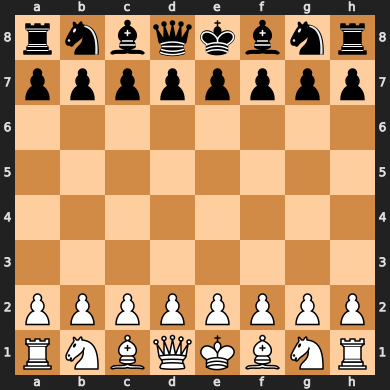

In [3]:
board=chess.Board()
board

In [4]:
base_name = './tmp/tf_weights.0.{}.h5'
tf_bot = agent(model,base_name.format(1))
deepbot = agent_MCTS(temperature=2,bot=tf_bot,game_state=board,verbose=2,max_iter=100)
move=deepbot.select_move(board)
move

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
MCTS - nodes:2326 Elapsed time: 1.30s = 0.02m nps=1791


Move.from_uci('e2e4')

In [5]:
moves,values=deepbot.get_move_values(board)

El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:2331 Elapsed time: 0.72s = 0.01m nps=3220


In [6]:
moves

[Move.from_uci('a2a4'),
 Move.from_uci('b2b4'),
 Move.from_uci('c2c4'),
 Move.from_uci('d2d4'),
 Move.from_uci('e2e4'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g4'),
 Move.from_uci('h2h4'),
 Move.from_uci('a2a3'),
 Move.from_uci('b2b3'),
 Move.from_uci('c2c3'),
 Move.from_uci('d2d3'),
 Move.from_uci('e2e3'),
 Move.from_uci('f2f3'),
 Move.from_uci('g2g3'),
 Move.from_uci('h2h3'),
 Move.from_uci('b1a3'),
 Move.from_uci('b1c3'),
 Move.from_uci('g1f3'),
 Move.from_uci('g1h3')]

In [7]:
values

array([0.56762324, 0.55144209, 0.58203784, 0.60890872, 0.61180911,
       0.57891041, 0.58027871, 0.57512607, 0.55659069, 0.52204359,
       0.49626074, 0.51817438, 0.53344775, 0.55283375, 0.54057504,
       0.58994079, 0.54309492, 0.57811645, 0.57517598, 0.38031822])

In [8]:
from chesslab.utils import join_and_sort
join_and_sort(moves,values)

array([[Move.from_uci('e2e4'), 0.6118091148666188],
       [Move.from_uci('d2d4'), 0.608908718579436],
       [Move.from_uci('h2h3'), 0.5899407883320958],
       [Move.from_uci('c2c4'), 0.5820378449003575],
       [Move.from_uci('g2g4'), 0.5802787097532358],
       [Move.from_uci('f2f4'), 0.57891040711891],
       [Move.from_uci('b1c3'), 0.5781164498164736],
       [Move.from_uci('g1f3'), 0.5751759759311018],
       [Move.from_uci('h2h4'), 0.5751260743105322],
       [Move.from_uci('a2a4'), 0.5676232415276605],
       [Move.from_uci('a2a3'), 0.5565906871448864],
       [Move.from_uci('f2f3'), 0.5528337462874483],
       [Move.from_uci('b2b4'), 0.551442086159646],
       [Move.from_uci('b1a3'), 0.543094922911446],
       [Move.from_uci('g2g3'), 0.5405750446491413],
       [Move.from_uci('e2e3'), 0.53344775390625],
       [Move.from_uci('b2b3'), 0.5220435889991554],
       [Move.from_uci('d2d3'), 0.518174375806536],
       [Move.from_uci('c2c3'), 0.4962607394443469],
       [Move.from_uc

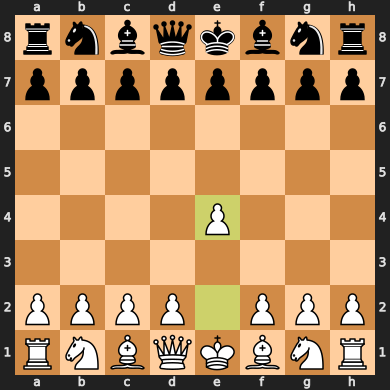

In [9]:
board.push(move)
board

In [10]:
kaufman_test(deepbot)

El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:4803 Elapsed time: 2.25s = 0.04m nps=2135
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:4192 Elapsed time: 1.43s = 0.02m nps=2934
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:3773 Elapsed time: 1.36s = 0.02m nps=2780
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:4654 Elapsed time: 1.53s = 0.03m nps=3049
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:4477 Elapsed time: 1.29s = 0.02m nps=3482
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:3082 Elapsed time: 1.09s = 0.02m nps=2835
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:3549 Elapsed time: 1.14s = 0.02m nps=3103
El estado de juego no corresponde con el de la r

0.16

In [11]:
deepbot.set_max_iter(1000)
acc,acc_w,data = kaufman_test(deepbot,details=1)
print('Accuracy: {:.0f}/25 = {} | weighted = {:.2}'.format(acc*25,acc,acc_w))
print('id & Mejor & Pos. & Total & Peso & V.F.E & Pred. & V.F.E. ')
for i,(best_move,value,move_predicted,value_predicted,rank,tot,weight) in enumerate(data):
    print('{:02d} & {} & {} & {} & {:.4f} & {:.4f} & {} & {:.4f}  \\\\'.format(i+1,best_move,rank,tot,weight,value,move_predicted,value_predicted))
pd.DataFrame(data,columns=["best_move","value","move_predicted","value_predicted","rank","total moves","weight"])

El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:48429 Elapsed time: 12.51s = 0.21m nps=3873
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:41512 Elapsed time: 11.24s = 0.19m nps=3694
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:37105 Elapsed time: 10.11s = 0.17m nps=3669
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:45593 Elapsed time: 13.40s = 0.22m nps=3403
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:42755 Elapsed time: 11.76s = 0.20m nps=3637
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:29882 Elapsed time: 8.58s = 0.14m nps=3484
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:35718 Elapsed time: 10.60s = 0.18m nps=3370
El estado de juego no corresponde c

,best_move,value,move_predicted,value_predicted,rank,total moves,weight
0,e4f6,0.553781,c1c7,0.730624,42,48,0.127660
1,f5d4,0.316608,a5d2,0.473467,19,39,0.526316
2,e1d1,0.591689,f2c5,0.760501,16,38,0.594595
3,b1b2,0.781862,b1b2,0.781862,1,47,1.000000
4,g5c1,0.578352,g5c1,0.578352,1,48,1.000000
5,a3a2,0.402564,h7h6,0.407025,3,31,0.933333
6,b7e4,0.387855,c7c4,0.404448,3,33,0.937500
7,h7h6,0.455468,f8f2,0.542969,9,39,0.789474
8,f3e2,0.504050,h1f1,0.604021,17,35,0.529412
9,d5c3,0.472634,c7c3,0.522335,11,41,0.750000


In [12]:
deepbot.set_max_iter(10000)
acc,acc_w,data = kaufman_test(deepbot,details=1)
print('Accuracy: {:.0f}/25 = {} | weighted = {:.2}'.format(acc*25,acc,acc_w))
print('id & Mejor & Pos. & Total & Peso & V.F.E & Pred. & V.F.E. ')
for i,(best_move,value,move_predicted,value_predicted,rank,tot,weight) in enumerate(data):
    print('{:02d} & {} & {} & {} & {:.4f} & {:.4f} & {} & {:.4f}  \\\\'.format(i+1,best_move,rank,tot,weight,value,move_predicted,value_predicted))
pd.DataFrame(data,columns=["best_move","value","move_predicted","value_predicted","rank","total moves","weight"])

El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:476188 Elapsed time: 124.51s = 2.08m nps=3824
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:399842 Elapsed time: 113.88s = 1.90m nps=3511
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:336195 Elapsed time: 96.23s = 1.60m nps=3494
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:445322 Elapsed time: 130.55s = 2.18m nps=3411
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:391440 Elapsed time: 113.00s = 1.88m nps=3464
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:294115 Elapsed time: 84.56s = 1.41m nps=3478
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:374195 Elapsed time: 111.30s = 1.86m nps=3362
El estado de juego no 

,best_move,value,move_predicted,value_predicted,rank,total moves,weight
0,e4f6,0.555685,c1c7,0.666162,44,48,0.085106
1,f5d4,0.319567,a5d2,0.432408,18,39,0.552632
2,e1d1,0.571164,g2g4,0.643339,13,38,0.675676
3,b1b2,0.755570,d2d5,0.757818,2,47,0.978261
4,g5c1,0.439649,g5c1,0.439649,1,48,1.000000
5,a3a2,0.387202,h7h6,0.388915,2,31,0.966667
6,b7e4,0.376486,c7c5,0.392582,3,33,0.937500
7,h7h6,0.438031,e5e4,0.469712,7,39,0.842105
8,f3e2,0.486268,h1f1,0.566940,27,35,0.235294
9,d5c3,0.438464,c7f4,0.489178,14,41,0.675000


In [13]:
deepbot.set_max_iter(30000)
acc,acc_w,data = kaufman_test(deepbot,details=1)
print('Accuracy: {:.0f}/25 = {} | weighted = {:.2}'.format(acc*25,acc,acc_w))
print('id & Mejor & Pos. & Total & Peso & V.F.E & Pred. & V.F.E. ')
for i,(best_move,value,move_predicted,value_predicted,rank,tot,weight) in enumerate(data):
    print('{:02d} & {} & {} & {} & {:.4f} & {:.4f} & {} & {:.4f}  \\\\'.format(i+1,best_move,rank,tot,weight,value,move_predicted,value_predicted))
pd.DataFrame(data,columns=["best_move","value","move_predicted","value_predicted","rank","total moves","weight"])

El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:1421004 Elapsed time: 378.30s = 6.31m nps=3756
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:1104385 Elapsed time: 312.31s = 5.21m nps=3536
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz
MCTS - nodes:1051583 Elapsed time: 307.66s = 5.13m nps=3418
El estado de juego no corresponde con el de la raiz del arbol, se recreó la raiz


KeyboardInterrupt: 

In [ ]:
epochs=40
exact_acc = np.zeros(epochs)
weighted_acc = np.zeros(epochs)
train_acc_model = np.zeros(epochs)
test_acc_model = np.zeros(epochs)
deepbot.set_max_iter(1000)
for i in range(1,epochs+1):
    tf_bot = agent(model,base_name.format(i))
    deepbot = agent_MCTS(temperature=2,bot=tf_bot,game_state=board,verbose=0,max_iter=1000)
    acc,acc_w,_  = kaufman_test(deepbot,details=1)
    exact_acc[i-1]=acc
    weighted_acc[i-1]=acc_w
    train_acc_model[i-1] = tf_bot.history['train']['acc'][-1]
    test_acc_model[i-1] = tf_bot.history['test']['acc'][-1]


In [ ]:
path = 'E:/database/stockfish_14.exe'
stockfish = s_agent(path)
ss,ssp,_  = kaufman_test(stockfish,details=1)
print("Exactitud para función de stockfish usando prueba de Kaufman y prueba de Kaufman ponderada\n {} | {:.2f}".format(ss,ssp))
ss = np.repeat(ss,epochs)
ssp = np.repeat(ssp,epochs)

In [ ]:
x = np.arange(epochs)+1
plt.plot(x,train_acc_model*100)
plt.plot(x,test_acc_model*100)
plt.plot(x,exact_acc*100)
plt.plot(x,weighted_acc*100)
plt.plot(x,ss*100,linestyle='dotted')
plt.plot(x,ssp*100,linestyle='dashed')
plt.title('Exactitud por epoca de entrenamiento')
plt.xlabel('Epoca de entrenamiento')
plt.ylabel('Exactitud')
plt.legend(['Exactitud entrenamiento','Exactitud prueba','Prueba de kaufman','Prueba de kaufman ponderada','Prueba de kauman Stockfish','Prueba de Kaufman ponderada Stockfish'],bbox_to_anchor=(1, 1),loc=2)
plt.grid()
plt.savefig('grafica.png',bbox_inches="tight")
plt.show()

In [ ]:
train_acc_model

In [ ]:
print('Epoca & Conjunto de & Conjunto & Prueba & Prueba de \\\\')
print(' & entrenamiento & de prueba & de Kaufman & Kaufman ponderada \\\\')
for i in range(epochs):
    print('{:02d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(i+1,100*train_acc_model[i],100*test_acc_model[i],100*exact_acc[i],100*weighted_acc[i]))
data = np.stack((train_acc_model,test_acc_model,exact_acc,weighted_acc),axis=1)
pd.DataFrame(data,index=x,columns=["Conjunto de entrenamiento","Conjunto de prueba","Prueba de kaufman","Prueba de kaufman ponderada"])